In [1]:
!pip install -q -U transformers
!pip install -q -U accelerate
!pip install -q -U bitsandbytes
!pip install scikit-multilearn
!pip install datasets
!pip install peft
!pip install seaborn
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 1.9 MB/s eta 0:00:00


In [2]:
import os
import random
import functools
import csv
import pandas as pd
import numpy as np
import torch
import warnings
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
from skmultilearn.model_selection import iterative_train_test_split
from datasets import Dataset, DatasetDict
from pathlib import Path
from peft import (
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model
)
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
sns.set_style("whitegrid")
warnings.simplefilter('ignore')

In [5]:
!nvidia-smi

Wed Apr 17 19:43:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load Data

In [6]:
# Run this cell if you are using Google Colaboratory

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = Path(f"/content/drive/MyDrive/ITMO/RW'23")
# BASE_DIR = Path(f"/content/drive/MyDrive/{your_path}")
DATA_DIR = BASE_DIR.joinpath("data")  # Please upload the data_quality_estim.csv dataset to the data folder

FILE_NAME = "words_consistensy_wordset_dataset_agg.csv"

FILE_QUAL = DATA_DIR.joinpath(FILE_NAME)

Mounted at /content/drive


In [ ]:
BASE_DIR = Path('Mistral7B_LoRA_class.ipynb').resolve().parent.parent
DATA_DIR = BASE_DIR.joinpath('matveeva/datasets')

FILE_NAME_QUAL = 'data_quality_estim_4classes.csv'

FILE_QUAL = DATA_DIR.joinpath(FILE_NAME_QUAL)

In [7]:
data_quality = pd.read_csv(FILE_QUAL)
data_quality.head(10)

,INPUT:wordset,INPUT:dataset_name,OUTPUT:quality,homogenity,assessment
0,able amaze fill glad stop daily fantastic move...,amazon_food,"['rather_bad', 'bad', 'rather_bad']",0.7,-1
1,able amaze fill stop glad daily fantastic move...,amazon_food,"['bad', 'rather_good', 'rather_bad', 'rather_b...",0.5,-1
2,able amaze fill stop glad daily fantastic move...,amazon_food,"['bad', 'rather_bad', 'rather_bad']",0.7,-1
3,able amaze glad fill stop fantastic daily move...,amazon_food,"['bad', 'bad', 'bad']",1.0,-2
4,absolute church truth doug scripture symbol li...,20newsgroups,"['rather_good', 'bad', 'bad', 'rather_good', '...",0.6,1
5,absolute church truth mission nasa doug mars e...,20newsgroups,"['rather_bad', 'rather_bad', 'bad', 'rather_ba...",0.8,-1
6,absolute mission church nasa mars earth truth ...,20newsgroups,"['good', 'good', 'bad', 'good', 'good']",0.8,2
7,absolutely fast white rice service noodle terr...,amazon_food,"['rather_bad', 'bad', 'rather_bad', 'good', 'b...",0.5,-1
8,absolutely fast white super service customer r...,amazon_food,"['bad', 'good', 'rather_good', 'rather_good', ...",0.4,2
9,absolutely grain experience soon there's proce...,amazon_food,"['bad', 'bad', 'rather_bad']",0.7,-2


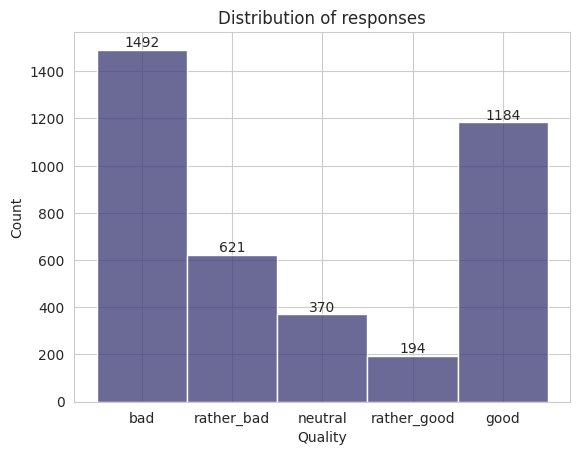

In [8]:
category_order = ["bad", "rather_bad", "neutral", "rather_good", "good"]
class_mapping = {
    -2: 'bad',
    -1: 'rather_bad',
    0: 'neutral',
    1: 'rather_good',
    2: 'good'
}
data_quality['assessment_word'] = data_quality['assessment'].map(class_mapping)

data_quality['assessment_word'] = pd.Categorical(data_quality['assessment_word'], categories=category_order, ordered=True)

ax = sns.histplot(data=data_quality, x="assessment_word", color="#3A3875")

for i in ax.containers:
    ax.bar_label(i,)

ax.set_title("Distribution of responses")
ax.set(xlabel="Quality", ylabel="Count")
plt.show()

In [9]:
# Let's change the label encoding
label_lst = ["bad", "rather_bad", "neutral", "rather_good", "good"]
for label in label_lst:
    data_quality[label] = np.zeros(data_quality.shape[0], dtype=int)

for ind, label in enumerate(data_quality["assessment_word"]):
    data_quality.at[ind, label] = 1

data_quality.head(10)

,INPUT:wordset,INPUT:dataset_name,OUTPUT:quality,homogenity,assessment,assessment_word,bad,rather_bad,neutral,rather_good,good
0,able amaze fill glad stop daily fantastic move...,amazon_food,"['rather_bad', 'bad', 'rather_bad']",0.7,-1,rather_bad,0,1,0,0,0
1,able amaze fill stop glad daily fantastic move...,amazon_food,"['bad', 'rather_good', 'rather_bad', 'rather_b...",0.5,-1,rather_bad,0,1,0,0,0
2,able amaze fill stop glad daily fantastic move...,amazon_food,"['bad', 'rather_bad', 'rather_bad']",0.7,-1,rather_bad,0,1,0,0,0
3,able amaze glad fill stop fantastic daily move...,amazon_food,"['bad', 'bad', 'bad']",1.0,-2,bad,1,0,0,0,0
4,absolute church truth doug scripture symbol li...,20newsgroups,"['rather_good', 'bad', 'bad', 'rather_good', '...",0.6,1,rather_good,0,0,0,1,0
5,absolute church truth mission nasa doug mars e...,20newsgroups,"['rather_bad', 'rather_bad', 'bad', 'rather_ba...",0.8,-1,rather_bad,0,1,0,0,0
6,absolute mission church nasa mars earth truth ...,20newsgroups,"['good', 'good', 'bad', 'good', 'good']",0.8,2,good,0,0,0,0,1
7,absolutely fast white rice service noodle terr...,amazon_food,"['rather_bad', 'bad', 'rather_bad', 'good', 'b...",0.5,-1,rather_bad,0,1,0,0,0
8,absolutely fast white super service customer r...,amazon_food,"['bad', 'good', 'rather_good', 'rather_good', ...",0.4,2,good,0,0,0,0,1
9,absolutely grain experience soon there's proce...,amazon_food,"['bad', 'bad', 'rather_bad']",0.7,-2,bad,1,0,0,0,0


In [10]:
system_prompt = ("You are a helpful assistant evaluating the top words of a topic model output for a given topic. "
                "You will recieve a list of words. Please rate the following words on a scale from -2 to 2 by answering "
                "on the question: 'Is it possible to determine a common topic for the presented word set or at least "
                "for the most part of the set?'. Use the criteria: '-2' when words seem to be unconnected, "
                "'-1' if the amount of irrelevant words is high to determine a topic or there is a mixture "
                "of topics, '1' if some words are too common or out of topic, '2' if words have a strong "
                "connection between them, '0' if it's hard for you to answer on the question. "
                "Print only answer without explanation.\n")

samples_system = []
for sample_text in tqdm(data_quality["INPUT:wordset"]):
    prompt = f"{system_prompt}Words: {sample_text}"
    samples_system.append(prompt)

print(samples_system[0])

100%|██████████| 3861/3861 [00:00<00:00, 262105.81it/s]

You are a helpful assistant evaluating the top words of a topic model output for a given topic. You will recieve a list of words. Please rate the following words on a scale from -2 to 2 by answering on the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'. Use the criteria: '-2' when words seem to be unconnected, '-1' if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, '1' if some words are too common or out of topic, '2' if words have a strong connection between them, '0' if it's hard for you to answer on the question. Print only answer without explanation.
Words: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter


In [11]:
# reshape
idx = data_quality.index.tolist()
text = data_quality["INPUT:wordset"]
labels = [[data_quality.iat[row_ind, 6], data_quality.iat[row_ind, 7], data_quality.iat[row_ind, 8],
           data_quality.iat[row_ind, 9], data_quality.iat[row_ind, 10]] for row_ind in range(data_quality.shape[0])]

labels = np.array(labels, dtype=int)

x_test = text[:int(0.3 * data_quality.shape[0])]
y_test = labels[:int(0.3 * data_quality.shape[0])]

text = text[int(0.3 * data_quality.shape[0]):].reset_index()["INPUT:wordset"]
labels = labels[int(0.3 * data_quality.shape[0]):]

dataset = [[text[i], labels[i]] for i in range(len(text))]

# set random seed
random.seed(0)
# shuffle data
random.shuffle(dataset)

text = np.array([dataset[i][0] for i in range(len(dataset))])
labels = np.array([dataset[i][1] for i in range(len(dataset))])
# text = np.array([dataset[i][0] for i in range(100)])
# labels = np.array([dataset[i][1] for i in range(100)])

# create label weights
label_weights = 1 - labels.sum(axis=0) / labels.sum()

# stratified train test split for multilabel datasets
row_ids = np.arange(len(labels))
train_idx, y_train, val_idx, y_val = iterative_train_test_split(row_ids[:,np.newaxis], labels, test_size = 0.2)
x_train = [text[i] for i in train_idx.flatten()]
x_val = [text[i] for i in val_idx.flatten()]

# create hf dataset
dataset = DatasetDict({
    'train': Dataset.from_dict({'text': x_train, 'labels': y_train}),
    'val': Dataset.from_dict({'text': x_val, 'labels': y_val})
})

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 2162
    })
    val: Dataset({
        features: ['text', 'labels'],
        num_rows: 541
    })
})

In [ ]:
# preprocess dataset with tokenizer
def tokenize_examples(examples, tokenizer, system_prompt):
    tokenized_inputs = tokenizer(examples['text'])
    tokenized_inputs['labels'] = examples['labels']
    return tokenized_inputs

In [ ]:
# model name
model_name = "mistralai/Mistral-7B-Instruct-v0.2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenized_ds = dataset.map(functools.partial(tokenize_examples, tokenizer=tokenizer, system_prompt=system_prompt), batched=True)
tokenized_ds = tokenized_ds.with_format('torch')

# qunatization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

# lora config
lora_config = LoraConfig(
    r = 4, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

# load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    num_labels=labels.shape[1]
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
model.config.pad_token_id = tokenizer.pad_token_id


Map:   0%|          | 0/2162 [00:00<?, ? examples/s]

Map:   0%|          | 0/541 [00:00<?, ? examples/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at mistralai/Mistral-7B-Instruct-v0.2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# define custom batch preprocessor
def collate_fn(batch, tokenizer):
    dict_keys = ['input_ids', 'attention_mask', 'labels']
    d = {k: [dic[k] for dic in batch] for k in dict_keys}
    d['input_ids'] = torch.nn.utils.rnn.pad_sequence(
        d['input_ids'], batch_first=True, padding_value=tokenizer.pad_token_id
    )
    d['attention_mask'] = torch.nn.utils.rnn.pad_sequence(
        d['attention_mask'], batch_first=True, padding_value=0
    )
    d['labels'] = torch.stack(d['labels'])
    return d

# define which metrics to compute for evaluation
def compute_metrics(p):
    predictions, labels = p
    f1_micro = f1_score(labels, predictions > 0, average = 'micro')
    f1_macro = f1_score(labels, predictions > 0, average = 'macro')
    f1_weighted = f1_score(labels, predictions > 0, average = 'weighted')

    accuracy = accuracy_score(labels, predictions > 0)


    return {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'accuracy': accuracy
    }

In [ ]:
# create custom trainer class to be able to pass label weights and calculate mutilabel loss
class CustomTrainer(Trainer):

    def __init__(self, label_weights, **kwargs):
        super().__init__(**kwargs)
        self.label_weights = label_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")

        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # compute custom loss
        loss = F.binary_cross_entropy_with_logits(logits, labels.to(torch.float32), pos_weight=self.label_weights)
        return (loss, outputs) if return_outputs else loss

In [ ]:
# define training args
training_args = TrainingArguments(
    output_dir='multilabel_classification',
    learning_rate=10e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy ='steps',
    save_strategy = 'steps',
    load_best_model_at_end = True,
    logging_steps=50,
    lr_scheduler_type='constant_with_warmup',
    logging_dir=BASE_DIR.joinpath("data/checkpoints")
)

# train
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_ds['train'],
    eval_dataset = tokenized_ds['val'],
    tokenizer = tokenizer,
    data_collator = functools.partial(collate_fn, tokenizer=tokenizer),
    compute_metrics = compute_metrics,

    label_weights = torch.tensor(label_weights, device=model.device)
)

trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted,Accuracy
50,0.881500,0.590005,0.000000,0.000000,0.000000,0.000000
100,0.741500,1.102952,0.003663,0.004348,0.003496,0.001848
150,1.187200,0.579351,0.003690,0.001826,0.003680,0.001848


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted,Accuracy
50,0.881500,0.590005,0.000000,0.000000,0.000000,0.000000
100,0.741500,1.102952,0.003663,0.004348,0.003496,0.001848
150,1.187200,0.579351,0.003690,0.001826,0.003680,0.001848
200,3.136800,3.322809,0.292052,0.090415,0.132029,0.292052
250,1.853600,1.067804,0.402957,0.114888,0.231475,0.402957
300,2.153900,2.439244,0.395564,0.240379,0.380361,0.000000
350,1.878200,1.772877,0.048059,0.018342,0.004408,0.048059
400,1.650500,1.522707,0.463339,0.205303,0.363504,0.000000
450,2.178800,1.777847,0.000000,0.000000,0.000000,0.000000
500,1.344400,1.224208,0.301910,0.145829,0.176586,0.000000


TrainOutput(global_step=1082, training_loss=1.3077904336333495, metrics={'train_runtime': 5377.8627, 'train_samples_per_second': 0.804, 'train_steps_per_second': 0.201, 'total_flos': 4545957040128000.0, 'train_loss': 1.3077904336333495, 'epoch': 2.0})

In [ ]:
vars(trainer)

{'args': TrainingArguments(
 _n_gpu=1,
 accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
 adafactor=False,
 adam_beta1=0.9,
 adam_beta2=0.999,
 adam_epsilon=1e-08,
 auto_find_batch_size=False,
 bf16=False,
 bf16_full_eval=False,
 data_seed=None,
 dataloader_drop_last=False,
 dataloader_num_workers=0,
 dataloader_persistent_workers=False,
 dataloader_pin_memory=True,
 dataloader_prefetch_factor=None,
 ddp_backend=None,
 ddp_broadcast_buffers=None,
 ddp_bucket_cap_mb=None,
 ddp_find_unused_parameters=None,
 ddp_timeout=1800,
 debug=[],
 deepspeed=None,
 disable_tqdm=False,
 dispatch_batches=None,
 do_eval=True,
 do_predict=False,
 do_train=False,
 eval_accumulation_steps=None,
 eval_delay=0,
 eval_steps=50,
 evaluation_strategy=steps,
 fp16=False,
 fp16_backend=auto,
 fp16_full_eval=False,
 fp16_opt_level=O1,
 fsdp=[],
 fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_v2': False, 'xla_fsdp_grad_ckpt': Fals

In [ ]:
loss_df = pd.DataFrame(trainer.state.log_history)

loss_lst = [item for item in loss_df["loss"] if not(pd.isnull(item))]
epoch_lst = loss_df["epoch"]
eval_loss_lst = [item for item in loss_df["eval_loss"] if not(pd.isnull(item))]

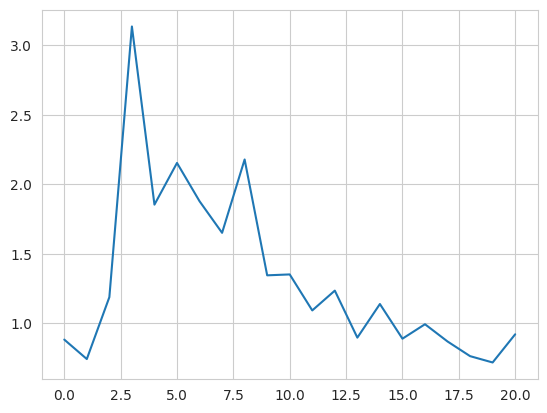

In [ ]:
plt.plot(loss_lst)

In [ ]:
models_dir = BASE_DIR.joinpath('matveeva/models')

peft_model_id = 'Mistral-7B_4bit_LoRA_class'

model_dir = models_dir.joinpath(peft_model_id)

In [ ]:
# save model
trainer.model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

("/content/drive/MyDrive/ITMO/RW'23/matveeva/models/Mistral-7B_4bit_LoRA_class/tokenizer_config.json",
 "/content/drive/MyDrive/ITMO/RW'23/matveeva/models/Mistral-7B_4bit_LoRA_class/special_tokens_map.json",
 "/content/drive/MyDrive/ITMO/RW'23/matveeva/models/Mistral-7B_4bit_LoRA_class/tokenizer.model",
 "/content/drive/MyDrive/ITMO/RW'23/matveeva/models/Mistral-7B_4bit_LoRA_class/added_tokens.json",
 "/content/drive/MyDrive/ITMO/RW'23/matveeva/models/Mistral-7B_4bit_LoRA_class/tokenizer.json")

## Load for Testing

In [22]:
id2label = {
    0: "bad",
    1: "bad",
    2: "neutral",
    3: "rather_good",
    4: "good"
}
label2id = {
    "bad": 0,
    "rather_bad": 1,
    "neutral": 2,
    "rather_good": 3,
    "good": 4
}

In [15]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForTokenClassification

models_dir = BASE_DIR.joinpath('matveeva/models')

peft_model_id = 'Mistral-7B_4bit_LoRA_class'

adapter_dir = models_dir.joinpath(peft_model_id)

config = PeftConfig.from_pretrained(adapter_dir)

# qunatization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

# load model
inference_model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path,
    num_labels=5,
    id2label=id2label,
    label2id=label2id,
    device_map='cuda',
    quantization_config=quantization_config
)

tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(inference_model, adapter_dir)

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at mistralai/Mistral-7B-Instruct-v0.2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [16]:
x_test

0       able amaze fill glad stop daily fantastic move...
1       able amaze fill stop glad daily fantastic move...
2       able amaze fill stop glad daily fantastic move...
3       able amaze glad fill stop fantastic daily move...
4       absolute church truth doug scripture symbol li...
                              ...                        
1153    enjoy strong blend morning brew bitter smooth ...
1154    enjoy strong morning brew bitter blend packet ...
1155    enjoy strong morning brew blend bitter smooth ...
1156    enough drinking black fan wife close aftertast...
1157    entry launch remark rule satellite european bu...
Name: INPUT:wordset, Length: 1158, dtype: object

In [ ]:
model_res = []
for test_sample in tqdm(x_test):
    inputs = tokenizer(test_sample, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    tokens = inputs.tokens()
    predictions = np.argmax(torch.nn.functional.softmax(logits))

    model_res.append(predictions.tolist())

100%|██████████| 1158/1158 [13:47<00:00,  1.40it/s]


In [ ]:
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): MistralForSequenceClassification(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
   

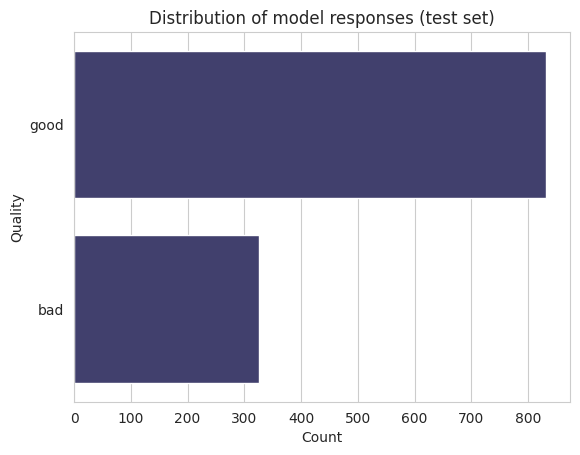

In [ ]:
class_res = [id2label[class_id] for class_id in model_res]

ax = sns.countplot(data=class_res, color="#3A3875")
ax.set_title("Distribution of model responses (test set)")
ax.set(xlabel="Count", ylabel="Quality")
plt.show()

In [ ]:
y_test = [np.argmax(sample) for sample in y_test]
y_test = [id2label[class_id] for class_id in y_test]

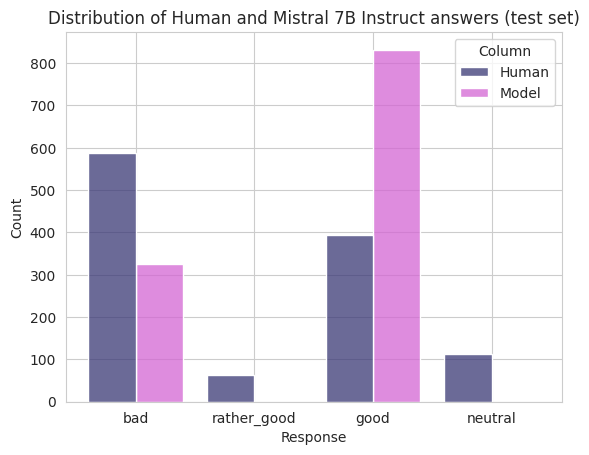

In [ ]:
res_df = pd.DataFrame(data={
    "Human": y_test,
    "Model": class_res
})

df_long = res_df.melt(var_name='Column', value_name='Response')

palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge', shrink=0.8, palette=palette_colors)

plt.title('Distribution of Human and Mistral 7B Instruct answers (test set)')
plt.show()

In [ ]:
print("Accuracy:", round(accuracy_score(y_test, class_res), 4))
print("F1-score (weighted):", round(f1_score(y_test, class_res, average="weighted"), 4))

Accuracy: 0.3921
F1-score (weighted): 0.3443


In [ ]:
res_df["Model"].value_counts()

Model
good    832
bad     326
Name: count, dtype: int64

## Inference on Entire Dataset

In [17]:
data_quality.head(10)

,INPUT:wordset,INPUT:dataset_name,OUTPUT:quality,homogenity,assessment,assessment_word,bad,rather_bad,neutral,rather_good,good
0,able amaze fill glad stop daily fantastic move...,amazon_food,"['rather_bad', 'bad', 'rather_bad']",0.7,-1,rather_bad,0,1,0,0,0
1,able amaze fill stop glad daily fantastic move...,amazon_food,"['bad', 'rather_good', 'rather_bad', 'rather_b...",0.5,-1,rather_bad,0,1,0,0,0
2,able amaze fill stop glad daily fantastic move...,amazon_food,"['bad', 'rather_bad', 'rather_bad']",0.7,-1,rather_bad,0,1,0,0,0
3,able amaze glad fill stop fantastic daily move...,amazon_food,"['bad', 'bad', 'bad']",1.0,-2,bad,1,0,0,0,0
4,absolute church truth doug scripture symbol li...,20newsgroups,"['rather_good', 'bad', 'bad', 'rather_good', '...",0.6,1,rather_good,0,0,0,1,0
5,absolute church truth mission nasa doug mars e...,20newsgroups,"['rather_bad', 'rather_bad', 'bad', 'rather_ba...",0.8,-1,rather_bad,0,1,0,0,0
6,absolute mission church nasa mars earth truth ...,20newsgroups,"['good', 'good', 'bad', 'good', 'good']",0.8,2,good,0,0,0,0,1
7,absolutely fast white rice service noodle terr...,amazon_food,"['rather_bad', 'bad', 'rather_bad', 'good', 'b...",0.5,-1,rather_bad,0,1,0,0,0
8,absolutely fast white super service customer r...,amazon_food,"['bad', 'good', 'rather_good', 'rather_good', ...",0.4,2,good,0,0,0,0,1
9,absolutely grain experience soon there's proce...,amazon_food,"['bad', 'bad', 'rather_bad']",0.7,-2,bad,1,0,0,0,0


In [18]:
model_res_inference = []
for sample in tqdm(data_quality["INPUT:wordset"]):
    inputs = tokenizer(sample, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    tokens = inputs.tokens()
    predictions = np.argmax(torch.nn.functional.softmax(logits))
    model_res_inference.append(predictions.tolist())

100%|██████████| 3861/3861 [44:59<00:00,  1.43it/s]


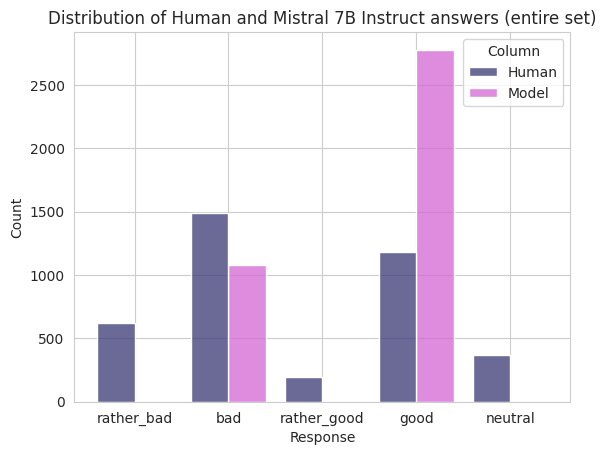

In [25]:
# model_res_inference = [id2label[class_id] for class_id in model_res_inference]
inference_df = pd.DataFrame(data={
    "Human": data_quality["assessment_word"],
    "Model": model_res_inference
})

df_long = inference_df.melt(var_name='Column', value_name='Response')

palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge', shrink=0.8, palette=palette_colors)

plt.title('Distribution of Human and Mistral 7B Instruct answers (entire set)')
plt.show()

In [26]:
print("Accuracy:", round(accuracy_score(inference_df["Human"], inference_df["Model"]), 4))
print("F1-score (weighted):", round(f1_score(inference_df["Human"], inference_df["Model"], average="weighted"), 4))

Accuracy: 0.344
F1-score (weighted): 0.2707


In [30]:
inference_df["wordset"] = data_quality["INPUT:wordset"]

inference_dir = BASE_DIR.joinpath('data/results')
res_file = inference_dir.joinpath("text_coherence_mistral_7B_LoRA_5classification.csv")
inference_df.to_csv(res_file)